#  Testing Skyfield and satellite Doppler factors

In [3]:
# just run this cell once to install the Skyfield module locally in your workspace, then delete it.  You won't need it again.
# !pip3 install --user skyfield

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skyfield.api import load, wgs84, EarthSatellite
from sgp4.api import Satrec, WGS84
import pandas as pd
import pickle 
c = 299792.458 # speed of light in km/s

In [4]:
# read in some satellite TLEs to work with
stations_url = 'http://celestrak.com/NORAD/elements/amateur.txt'
satellites = load.tle_file(stations_url)
by_name = {sat.name: sat for sat in satellites}

#pick out the LUSAT satellite, as an example
sat = by_name['LUSAT (LO-19)']
# print(sat)

# set up a timescale and an observing location
ts = load.timescale()
observatory  = wgs84.latlon(55.90260773318829, -4.3077694373606460) # Acre Road
t = ts.utc(2021, 8, 18, 13, 40, np.linspace(0,1000))


doppler_curves = []
for satellite in satellites:
    pos = (satellite - observatory).at(t)
    _, _, the_range, _, _, range_rate = pos.frame_latlon_and_rates(observatory)
    doppler_curves.append(1-range_rate.km_per_s/c)

doppler = doppler_curves[0]
# _, _, the_range, _, _, range_rate = pos.frame_latlon_and_rates(observatory)
# compute the Dopper factor over an interval of 1000 seconds as the satellite passes
# pos = (sat - observatory).at(t)
# doppler = (1-range_rate.km_per_s/c)

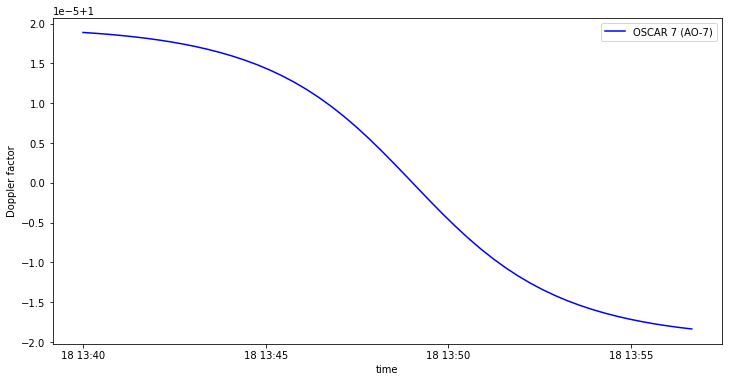

In [5]:
n = 0
plt.figure(figsize=(12,6))
plt.plot(t.utc_datetime(), doppler_curves[n],'b',label=satellites[n].name)
plt.xlabel('time')
plt.ylabel('Doppler factor' )
plt.legend()
plt.show()

We now generate a new satellite object from the paremeters of `sat` (each accessed using `sat.model.xxx`).  We replicate all these parameters explicitly into a new satellite record caled `satrecc` and then generate a new satellite object `newsat` with these parameters using `EarthSatellite.from_satrec`.

The six orbital parameters used in TLEs are $e$ (eccentricity), $i$ (inclination), $\Omega$ (longitude of the ascending node), $\omega$ (argument of periapsis), $n$ (mean motion) and $M_0$ (mean anomaly at epoch) defined at an epoch $T$.  Inaddition we have the ballistic drag coefficient $b^*$, that defined the 'air resistance' for the satellite.

The epoch calculation is a little fiddly, as the sgp4 epoch held as days since 1949 December 31 00:00 UT, whereas the `sat.model` epoch parameters are full julian date. 

We will change the orbital inclination by `delta_i` and see what effect it has on the Dopper factor.

In [6]:
delta_i = 0.1 # we'll change the inclination by this amount, to see the effect it has.
satrec = Satrec()
satrec.sgp4init(
    WGS84,           # gravity model
    'i',             # 'a' = old AFSPC mode, 'i' = improved mode
    sat.model.satnum,     # satnum: Satellite number
    sat.model.jdsatepoch + (sat.model.epochdays %1) - 2433281.5,       # epoch: days since 1949 December 31 00:00 UT
    sat.model.bstar,      # bstar: drag coefficient (/earth radii)
    sat.model.ndot,       # ndot: ballistic coefficient (revs/day) -- ignored by sgp4
    sat.model.nddot,      # nddot: second derivative of mean motion (revs/day^3)  -- ignored by sgp4
    sat.model.ecco,       # ecco: eccentricity, e
    sat.model.argpo,      # argpo: argument of perigee (radians), omega
    sat.model.inclo + delta_i,      # inclo: inclination (radians), i.  We've changed this by delta_i
    sat.model.mo,         # mo: mean anomaly (radians), M_0
    sat.model.no_kozai,   # no_kozai: mean motion (radians/minute), n
    sat.model.nodeo,      # nodeo: right ascension of ascending node (radians), Omega
    # sat.model.twoline2rv #look this one up!
)

# newsat = EarthSatellite.from_satrec(satrec, ts)
newsat = EarthSatellite.from_satrec(satrec, ts)
# calculate the new dopper factor for this new satellite
new_pos = (newsat -observatory).at(t)
_, _, new_range, _, _, new_range_rate = new_pos.frame_latlon_and_rates(observatory)
new_doppler = (1-new_range_rate.km_per_s/c)

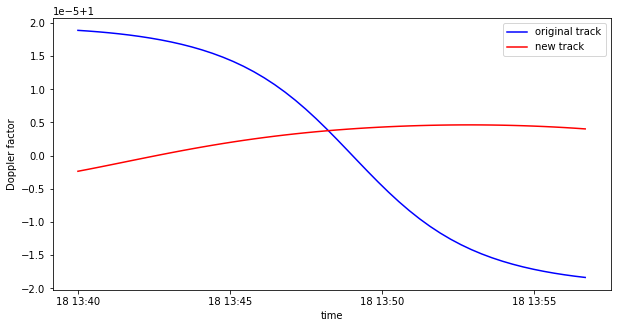

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(t.utc_datetime(), doppler,'b',label='original track')
plt.plot(t.utc_datetime(), new_doppler,'r',label = 'new track')
plt.xlabel('time')
plt.ylabel('Doppler factor' )
plt.legend()
plt.show()

### Try adding some Gaussian noise to the doppler curve

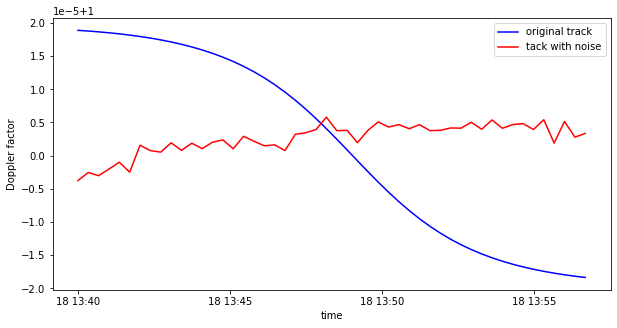

In [28]:
new_doppler
mu, sigma = 0, 0.000001
noise = np.random.normal(mu,sigma, len(doppler))
noisy_doppler = new_doppler+noise

plt.figure(figsize=(10, 5))
plt.plot(t.utc_datetime(), doppler,'b',label='original track')
plt.plot(t.utc_datetime(), noisy_doppler,'r',label = 'tack with noise')
plt.xlabel('time')
plt.ylabel('Doppler factor' )
plt.legend()
plt.show()

### Creating a dataset of doppler curves

The dataset will consist of data (doppler curve, data type [list]) and 6 targets (orbital parameters that were used to generate the doppler curve in the first place). It then gets converted into a pandas dataframe for convenience and saved as a pickle file.

In [22]:
import numpy as np
doppler_curves_dataset = []

for i in range(100000):

    eccentricity = np.random.rand()*0.35 #eccentricities up to 0.5 seems reasonable
    arg_of_perigee = np.random.rand()*2*np.pi
    inclination = np.random.uniform(0,np.pi/1.7)
    mean_anomaly = np.random.rand()*2*np.pi
    mean_motion = np.random.uniform(np.pi/18,np.pi/10)
    right_ascention = np.random.rand()*2*np.pi

    custom_satrec = Satrec()
    custom_satrec.sgp4init(
        WGS84,           # XXXgravity model
        'i',             # 'XXXa' = old AFSPC mode, 'i' = improved mode
        5,               # XXXsatnum: Satellite number
        18441.785,       # epoch: days since 1949 December 31 00:00 UT
        2.8098e-05,      # XXXbstar: drag coefficient (/earth radii)
        6.969196665e-13, # XXXndot: ballistic coefficient (revs/day)
        0.0,             # XXXnddot: second derivative of mean motion (revs/day^3)
        eccentricity,      # ecco: eccentricity, varies (0,1)
        arg_of_perigee,# argpo: argument of perigee(periapsis)(radians). varies(0,3.14)
        inclination,# inclo: inclination (radians), varies (0,pi/2)
        mean_anomaly,# mo: mean anomaly (radians), varies (0,3.14)
        mean_motion,# no_kozai: mean motion (radians/minute), varies (0,2pi)
        right_ascention# nodeo: right ascension of ascending node (radians)
    )

    newsat = EarthSatellite.from_satrec(custom_satrec, ts)
    # calculate the new dopper factor for this new satellite
    new_pos = (newsat -observatory).at(t)
    _, _, new_range, _, _, new_range_rate = new_pos.frame_latlon_and_rates(observatory)
    new_doppler = (1-new_range_rate.km_per_s/c)
    doppler_curves_dataset.append([new_doppler, eccentricity, arg_of_perigee, inclination, mean_anomaly, mean_motion, right_ascention])

In [30]:
df = pd.DataFrame(np.array(doppler_curves_dataset), columns='Data Eccentricity Arg_of_Perigee Inclination Mean_Anomaly Mean_Motion Right_Ascention'.split())
df.head()

with open('pandas_orbital_dataset.pickle', 'wb') as f:
    pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('list_orbital_dataset.pickle', 'wb') as f:
    pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

<ipython-input-30-bb964a283409>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(doppler_curves_dataset), columns='Data Eccentricity Arg_of_Perigee Inclination Mean_Anomaly Mean_Motion Right_Ascention'.split())
